In [1]:
import torch
from torch import nn

import pandas as pd

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# test_df = pd.read_csv('./resources/test_set.csv')
test_df = pd.read_csv('../labos/resources/test_set.csv')

In [4]:
class MusicClassifier(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(
                in_features=input_features, out_features=256, dtype=torch.float32
            ),
            nn.GELU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=256, out_features=128, dtype=torch.float32),
            nn.GELU(),
            nn.Dropout(p=0.2),
            nn.Linear(
                in_features=128, out_features=output_features, dtype=torch.float32
            ),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

In [5]:
loss_fn = nn.CrossEntropyLoss()

def accuracy_fn(y_true, y_pred):
    correct = (
        torch.eq(input=y_true, other=y_pred).sum().item()
    )  # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100  # Calcul simple de pourcentage
    return acc


In [6]:
def get_data(df: pd.DataFrame, device: str):
    # TODO: Séparer avec une nouvelle fonction get_test_data !
    # Prepare data
    X = (
        torch.from_numpy(df.drop(columns=["label"]).to_numpy())
        .type(torch.float32)
        .to(device)
    )
    y = torch.from_numpy(df["label"].to_numpy()).type(torch.long).to(device)

    # X_train, X_test, y_train, y_test = train_test_split(
    #     X, y, test_size=0.2, random_state=42
    # )
    return X, y

In [7]:
test_loss_history = []
test_acc_history = []

my_model = MusicClassifier(input_features=55, output_features=10)

my_model.load_state_dict(
    torch.load(
        # f="./resources/actual_model_fast.pth", map_location=torch.device("cpu")
        f="../resources/actual_model_fast.pth", map_location=torch.device("cpu")

    )
)

my_model.to(device)
X_test, y_test = get_data(df=test_df, device=device)



"""
Test
"""
my_model.eval()

with torch.inference_mode():
    # 1. Forward pass
    y_test_logits = my_model(X_test)
    y_test_pred = torch.softmax(y_test_logits, dim=1).argmax(dim=1)

    # 2. Metrics
    test_loss = loss_fn(y_test_logits, y_test)
    test_acc = accuracy_fn(y_pred=y_test_pred, y_true=y_test)

    # 2.1 Save metrics
    test_loss_history.append(test_loss.cpu().detach().numpy())
    test_acc_history.append(test_acc)
print("test_loss_history", test_loss_history)
print("test_acc_history", test_acc_history)

test_loss_history [array(9.196551, dtype=float32)]
test_acc_history [23.495286439448876]


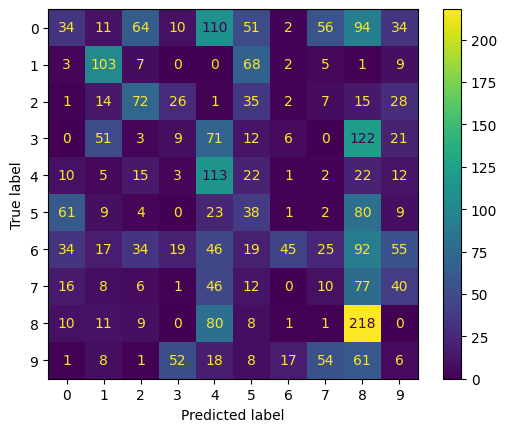

In [8]:
ConfusionMatrixDisplay(
    confusion_matrix(y_test.cpu(), y_test_pred.cpu().numpy())
).plot()